<a href="https://colab.research.google.com/github/R267/webster-homeworks/blob/main/homework2_webster.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms

# Define data transform
transform = transforms.Compose([
        transforms.ToTensor(),
])

# Create training and validation split of data
train_split_all = datasets.MNIST('./data', train=True, download=True, transform=transform)

# Limit amount of training data
N = 1500
indices = torch.randperm(len(train_split_all))[:N]
train_split = Subset(train_split_all, indices)
test_split = datasets.MNIST('./data', train=False, download=True, transform=transform)

# create dataloaders for train and test splits
train_dataloader = DataLoader(train_split, shuffle=True, batch_size=50, num_workers=1)
test_dataloader = DataLoader(test_split, shuffle=False, batch_size=50, num_workers=1)

100%|██████████| 9.91M/9.91M [00:00<00:00, 16.1MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 483kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 3.87MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 12.7MB/s]


0 torch.Size([50, 1, 28, 28]) torch.Size([50])
tensor(1.)


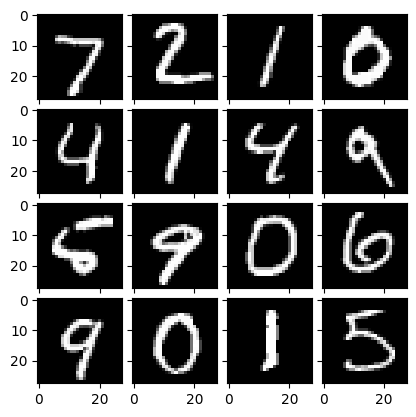

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

# get batch from dataloader
sampler = enumerate(test_dataloader)
batch_idx, (x, y) = next(sampler)
print(batch_idx, x.shape, y.shape)

# select sample images
images = [x[i].squeeze().numpy() for i in range(16)]
print(x.max())

# create and display plot
fig = plt.figure()
grid = ImageGrid(fig, 111,
                 nrows_ncols=(4, 4),
                 axes_pad=0.1,
)
for axis, image in zip(grid, images):
    # Iterating over the grid returns the Axes.
    axis.imshow(image, cmap='gray')

plt.show()

# 0, 1, 2, 3, 4, 5, 6, 7, 8, 9

In [ ]:
import torch
import torch.nn as nn

# визначення MLP-моделі
class MLP(nn.Module):
  def __init__(self, input_size=28*28, hidden_size=8, output_size=10):
    super(MLP, self).__init__()

    self.layer_1 = nn.Linear(input_size, hidden_size, bias=False)
    self.layer_2 = nn.Linear(hidden_size, output_size, bias=False)

    self.act = nn.Sigmoid()

  def forward(self, x):
    x = torch.flatten(x, start_dim=1)
    h1 = self.layer_1(x)
    a1 = self.act(h1)
    h2 = self.layer_2(a1)
    y = self.act(h2)
    return y


In [ ]:
import torch.optim as optim
from torch.nn.functional import one_hot
from torcheval.metrics import MulticlassConfusionMatrix
# гіперпараметри
num_epochs = 150
lr = 1

# створення моделі з hidden_size=8
model = MLP(input_size=28*28, hidden_size=8, output_size=10).to('cuda')

optimizer = optim.SGD(model.parameters(), lr=lr)
mse_loss = nn.MSELoss()
confusion_matrix = MulticlassConfusionMatrix(num_classes=10)

def train(model, optimizer, dataloader):
  model.train()
  losses, accuracies = [], []
  for x, y in dataloader:
    x, y = x.to('cuda'), y.to('cuda')
    optimizer.zero_grad()
    pred = model(x)
    loss = mse_loss(pred, one_hot(y, num_classes=10).float())
    loss.backward()
    optimizer.step()
    accuracy = (torch.argmax(pred, dim=-1) == y).float().mean()
    losses.append(loss.cpu())
    accuracies.append(accuracy.cpu())
  return torch.stack(losses).mean(), torch.stack(accuracies).mean()

def test(model, dataloader, last=False):
  model.eval()
  losses, accuracies = [], []
  for x, y in dataloader:
    x, y = x.to('cuda'), y.to('cuda')
    pred = model(x)
    loss = mse_loss(pred, one_hot(y, num_classes=10).float())
    if last:
      confusion_matrix.update(torch.argmax(pred, dim=-1), y)
    accuracy = (torch.argmax(pred, dim=-1) == y).float().mean()
    losses.append(loss.cpu())
    accuracies.append(accuracy.cpu())
  return torch.stack(losses).mean(), torch.stack(accuracies).mean()

train_losses, test_losses = [], []
train_accuracies, test_accuracies = [], []

for epoch in range(num_epochs):
  train_loss, train_acc = train(model, optimizer, train_dataloader)
  test_loss, test_acc = test(model, test_dataloader, epoch==num_epochs-1)
  print(f'{epoch}: Train loss: {train_loss:.2f}, Accuracy: {train_acc:.2f}, Test loss: {test_loss:.2f}, Test Acc: {test_acc:.2f}')
  train_losses.append(train_loss.item())
  test_losses.append(test_loss.item())
  train_accuracies.append(train_acc.item())
  test_accuracies.append(test_acc.item())

mat = confusion_matrix.normalized('true')


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 5.6 MB/s eta 0:00:00
0: Train loss: 0.15, Accuracy: 0.10, Test loss: 0.10, Test Acc: 0.10
1: Train loss: 0.09, Accuracy: 0.15, Test loss: 0.09, Test Acc: 0.19
2: Train loss: 0.09, Accuracy: 0.16, Test loss: 0.09, Test Acc: 0.18
3: Train loss: 0.09, Accuracy: 0.20, Test loss: 0.09, Test Acc: 0.20
4: Train loss: 0.09, Accuracy: 0.22, Test loss: 0.09, Test Acc: 0.21
5: Train loss: 0.09, Accuracy: 0.23, Test loss: 0.09, Test Acc: 0.22
6: Train loss: 0.09, Accuracy: 0.21, Test loss: 0.09, Test Acc: 0.23
7: Train loss: 0.09, Accuracy: 0.25, Test loss: 0.09, Test Acc: 0.24
8: Train loss: 0.09, Accuracy: 0.26, Test loss: 0.09, Test Acc: 0.25
9: Train loss: 0.09, Accuracy: 0.28, Test loss: 0.09, Test Acc: 0.27
10: Train loss: 0.09, Accuracy: 0.29, Test loss: 0.09, Test Acc: 0.31
11: Train loss: 0.09, Accuracy: 0.34, Test loss: 0.09, Test Acc: 0.38
12: Train loss: 0.09, Accuracy: 0.39, Test loss: 0.09, Test Acc: 0.44
13: Train loss: 0.09

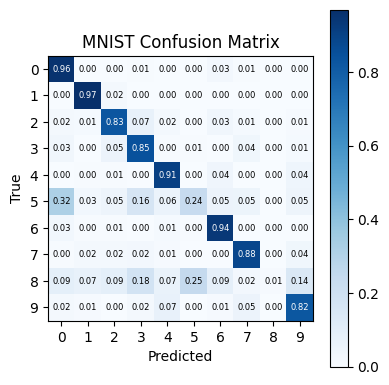

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_mnist_confusion_matrix(conf_matrix, title="MNIST Confusion Matrix"):
    fig, ax = plt.subplots(figsize=(4, 4))
    cax = ax.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    fig.colorbar(cax)
    ticks = np.arange(10)
    ax.set_xticks(ticks)
    ax.set_yticks(ticks)
    ax.set_xticklabels(ticks)
    ax.set_yticklabels(ticks)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    thresh = conf_matrix.max() / 2
    for i in range(10):
        for j in range(10):
            ax.text(j, i, f'{conf_matrix[i, j]:.2f}', ha='center', va='center',
                    color='white' if conf_matrix[i, j] > thresh else 'black', fontsize=6)
    plt.tight_layout()
    plt.show()

plot_mnist_confusion_matrix(mat)


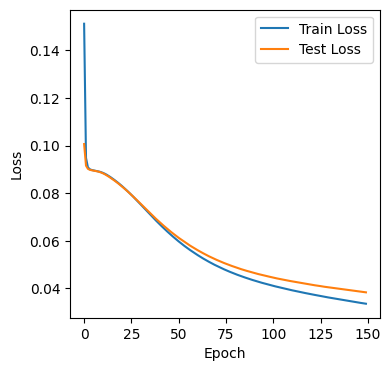

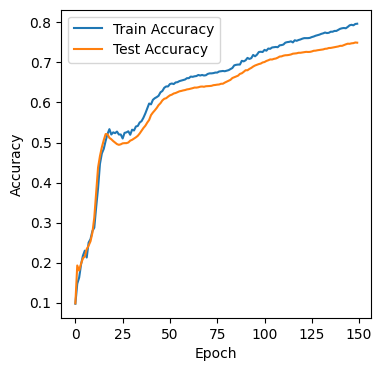

In [ ]:
plt.figure(figsize=(4, 4))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(4, 4))
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


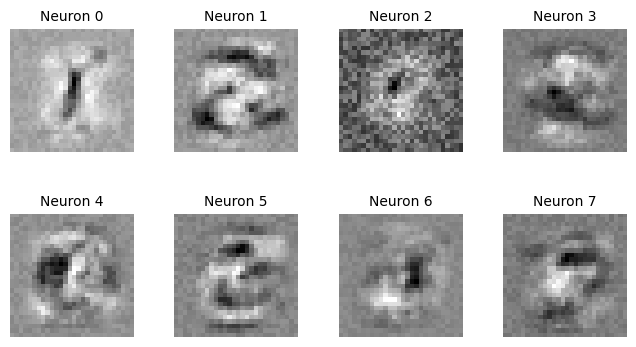

In [ ]:
import matplotlib.pyplot as plt

images = [model.layer_1.weight[i, :].detach().reshape(28, 28).cpu().numpy() for i in range(model.layer_1.weight.shape[0])]

n_rows, n_cols = 2, model.layer_1.weight.shape[0] // 2
fig, axes = plt.subplots(n_rows, n_cols, figsize=(2*n_cols, 4))
axes = axes.flatten()

for i, (ax, image) in enumerate(zip(axes, images)):
    ax.imshow(image, cmap='gray')
    ax.set_title(f'Neuron {i}', fontsize=10)
    ax.axis('off')

plt.subplots_adjust(wspace=0.3, hspace=0.5)
plt.show()



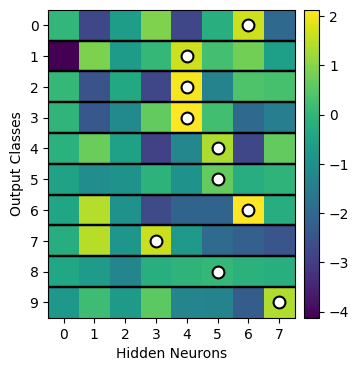

torch.Size([10, 8])


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

weights = model.layer_2.weight.detach().cpu()

fig = plt.figure(figsize=(6, 4))
im = plt.imshow(weights, aspect='equal')
plt.xticks(range(weights.shape[1]))
plt.yticks(range(weights.shape[0]))

for y in range(1, weights.shape[0]):
    plt.axhline(y - 0.5, color='black', linewidth=1.75)

for y, row in enumerate(weights):
    x = row.argmax().item()
    plt.plot(x, y, marker='o', color='black', markersize=9)
    plt.plot(x, y, marker='o', color='white', markersize=6)

plt.colorbar(im, shrink=1, pad=0.02)
plt.ylabel('Output Classes')
plt.xlabel('Hidden Neurons')
plt.show()

print(weights.shape)